#  Introduction 

Traffic collisions pose a significant risk to public safety and can result in varying degrees of victim injuries. Understanding the factors that contribute to the severity of injuries can greatly aid in developing effective accident prevention strategies and improving emergency response protocols. In this report, we explore the application of machine learning techniques to predict the severity of victim injuries in collisions where there is 1 party involved and 1 victim that is injured, using the comprehensive California Highway Patrol dataset. By leveraging this rich dataset, which encompasses various attributes related to accidents, collision factors, parties involved, and vehicle information, our aim is to develop accurate predictive models that can assist in determining injury severity. Questions that we hope to answer through this study are: 

&emsp; 1. How severe are injuries for a motorcyclist in a collision compared to all other vehicles on the road?

&emsp; 2. Do newer drivers get into more collisions on the road? 

&emsp; 3. Which county in California is most prone to collisions? 

&emsp; 4. Do vehicle safety equipment play a roll in victim degree of injury?

The outcomes of this study have the potential to inform traffic and vehicle safety initiatives.  

#  Data Preprocessing

The preprocessing process involves several essential steps to clean and transform the raw data into a usable format. These steps are as follows:

1. Analysis of Raw Data:  This step involves identifying the original dataset and studying its elements.

2. Data Transformation: In this step, the original values are computed and transformed into appropriate data types.

3. Data Preparation: Raw data is computed and processed to transform it into meaningful information.

##  Analysis of Raw Data

The dataset utilized in this research is sourced from the California Highway Patrol [1], encompassing collision data from January 1st, 2001, to December 2020. The dataset is provided in the form of an SQLite file, comprising four tables. With over 10 million rows in the dataset, an approach was adopted to extract a manageable sample size of 300,000 cases where there was only one party and one victim involved in the collision. This extraction process involved employing SQL queries and employing chunking techniques to precisely retrieve the necessary data for this study. The code for this extraction is below, however we have commented it out as we have created a CSV file from this extraction which is given alongside this report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# collisions_data, victims_data, parties_data = [], [], []
# switrs_conn = sqlite3.connect('/datasets/amann-gdrive/seng474_project/switrs.sqlite', timeout=60)

# for chunk in pd.read_sql_query("SELECT * FROM collisions WHERE party_count = '1'", switrs_conn, chunksize=10000):
#     collisions_data.append(chunk)
# collisions_data = pd.concat(collisions_data)

# for chunk in pd.read_sql_query("SELECT * FROM victims GROUP BY case_id HAVING COUNT(*) = 1", switrs_conn, chunksize=10000):
#     victims_data.append(chunk)
# victims_data = pd.concat(victims_data)

# for chunk in pd.read_sql_query("SELECT * FROM parties GROUP BY case_id HAVING COUNT(*) = 1", switrs_conn, chunksize=10000):
#     parties_data.append(chunk)
# parties_data = pd.concat(parties_data)

In [3]:
# collisions_data_sampled = collisions_data.sample(n = 300000, random_state=42)
# collisions_data_sampled.info()

In [4]:
# pd.set_option('display.max_columns', None)
# sample_merged = collisions_data_sampled.merge(parties_data, on="case_id", how="inner").merge(victims_data, on="case_id", how="inner")
# sample_merged.info(verbose=True)

In [5]:
# sample_merged.to_csv('/datasets/amann-gdrive/seng474_project/sample_merged.csv')

In [6]:
df = pd.read_csv('sample_merged.csv')
df = df.rename(columns={'Unnamed: 0':'number_of_collisions'})

### Histogram Analysis

We have examined histograms of relevant numerical features that potentially affect the degree of injury for victims. Here are some key observations based on these histograms:

1. **Age Distribution**: The majority of the victims fall within the age range of 18-25, indicating that this age group is on the road more and involved in more collisions. The data here shows evidence that newer drivers on the road are more reckless, but we will be taking a closer look at this in section 2.1.2.

2. **Alcohol-related Collisions**: Approximately 24,000 collisions involved alcohol, suggesting the influence of alcohol as a contributing factor in these incidents.

3. **Total Injuries:** Around 80,000 victims were injured in the collisions, emphasizing the significant impact of these incidents on the affected individuals.

4. **Severe Injuries:** Approximately 5,000 victims suffered severe injuries, highlighting the severity and potential long-term consequences of certain collisions.

5. **Collision Locations:** The histograms reveal that the majority of collisions occurred on main streets rather than on highways or at intersections. This indicates that main streets are more prone to such incidents. Specifically, about 50,000 collisions took place on the highway, while less than 10,000 occurred at intersections.

6. **Vehicle Collisions:** Looking at the types of collisions, it is apparent that the majority of the incidents involved vehicles, suggesting that vehicle-to-vehicle collisions are more prevalent.

These observations provide insights into the patterns and characteristics of the collisions and the resulting injuries. Understanding these factors can aid in developing strategies to prevent accidents, improve road safety, and potentially reduce the severity of injuries in future incidents.



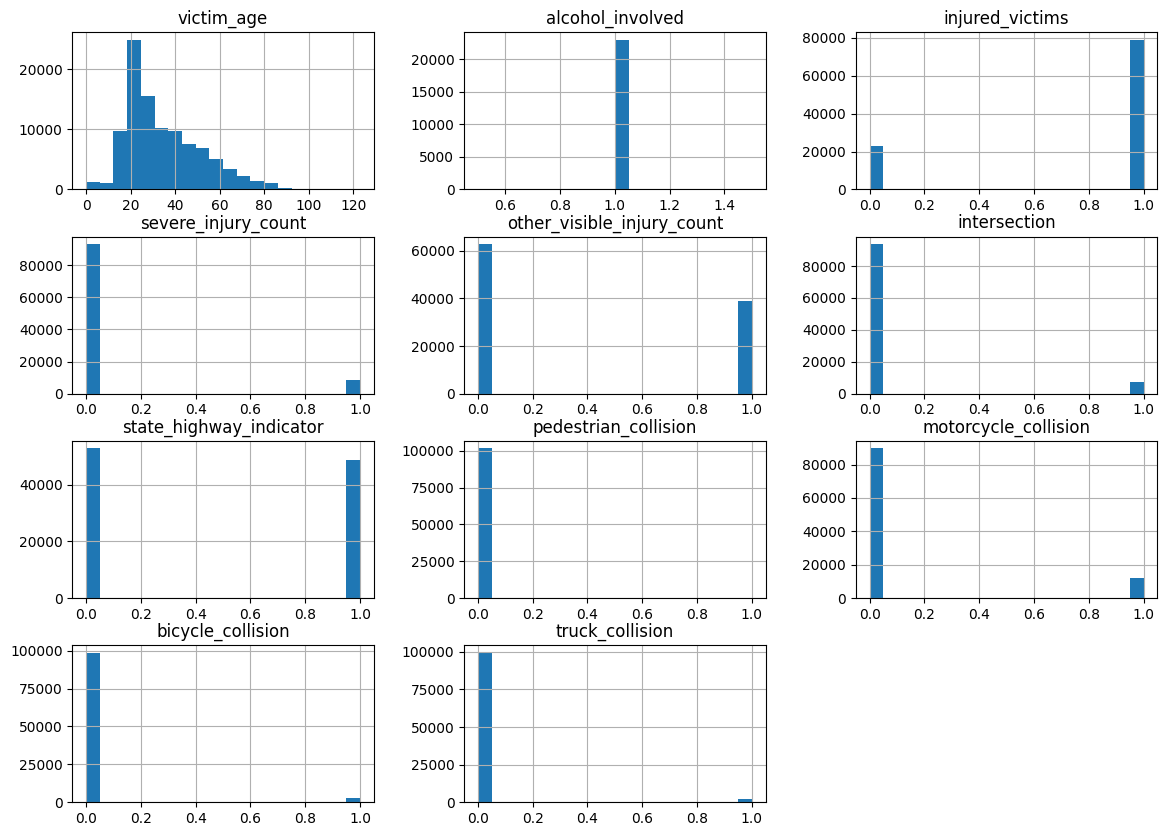

In [7]:
df.hist(column=["victim_age", "alcohol_involved","injured_victims","severe_injury_count","other_visible_injury_count", "intersection","state_highway_indicator", "pedestrian_collision",  "motorcycle_collision", "bicycle_collision", "truck_collision"],bins =20,figsize=(14, 10))
plt.show()

### Categorical Bar Chart Analysis

The bar charts presented below were generated to explore the data and gather insights about the target variable. 

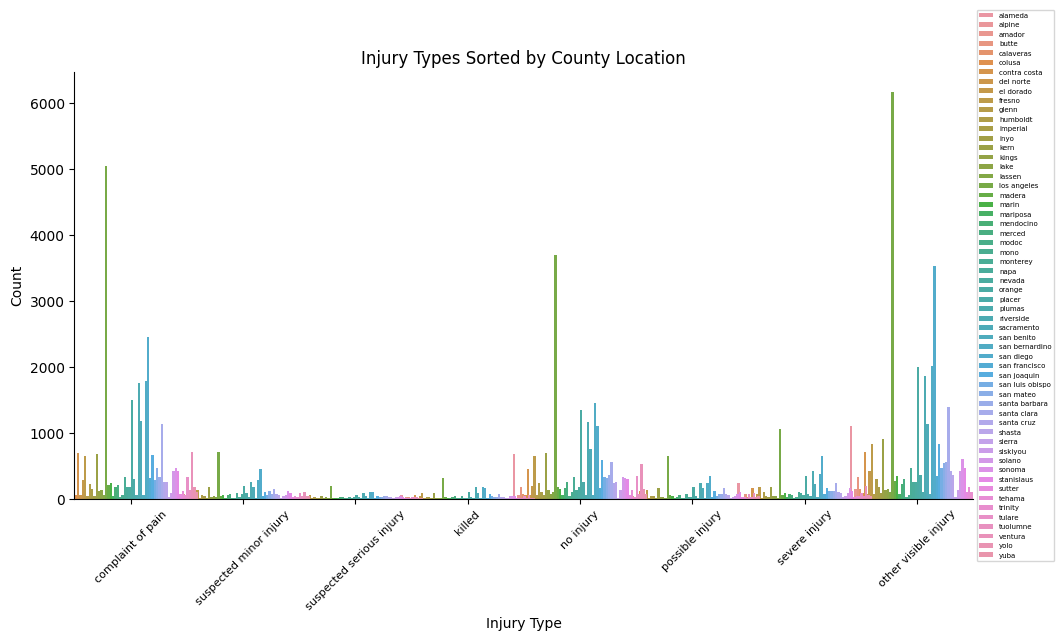

In [8]:
# Calculate the count of each injury type by county_location
count_data = df.groupby(['victim_degree_of_injury', 'county_location']).size().reset_index(name='count')

# Sort the y-axis (count) based on county_location
sorted_data = count_data.sort_values(by='county_location')

# Create the bar plot
g = sns.catplot(data=sorted_data, x='victim_degree_of_injury', y='count', 
            hue='county_location', kind='bar', legend=False, aspect=2, width=1.2)
g.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=5)

# Set labels and title
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.title('Injury Types Sorted by County Location')

# Rotate x-axis labels if needed,
plt.xticks(rotation=45, fontsize=8)

# Display the plot
plt.show()

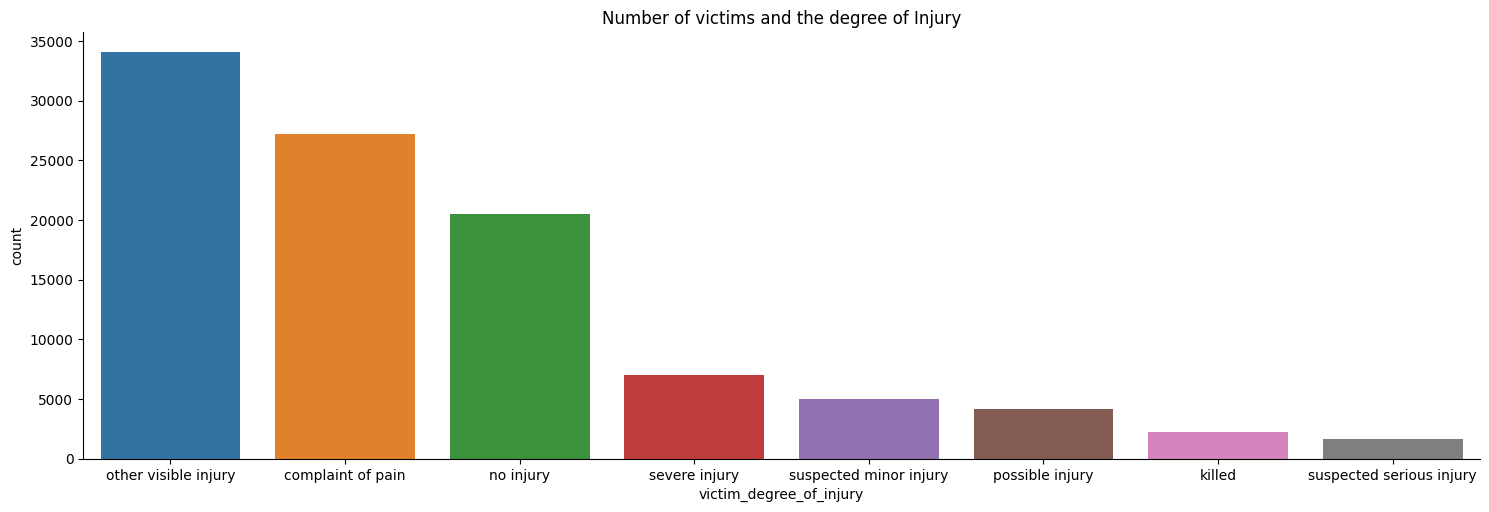

In [9]:
counts = df['victim_degree_of_injury'].value_counts().reset_index()
counts.columns = ['victim_degree_of_injury', 'count']

sns.catplot(data=counts, x='victim_degree_of_injury', y='count', kind='bar', aspect=3)

plt.title('Number of victims and the degree of Injury')
plt.show()

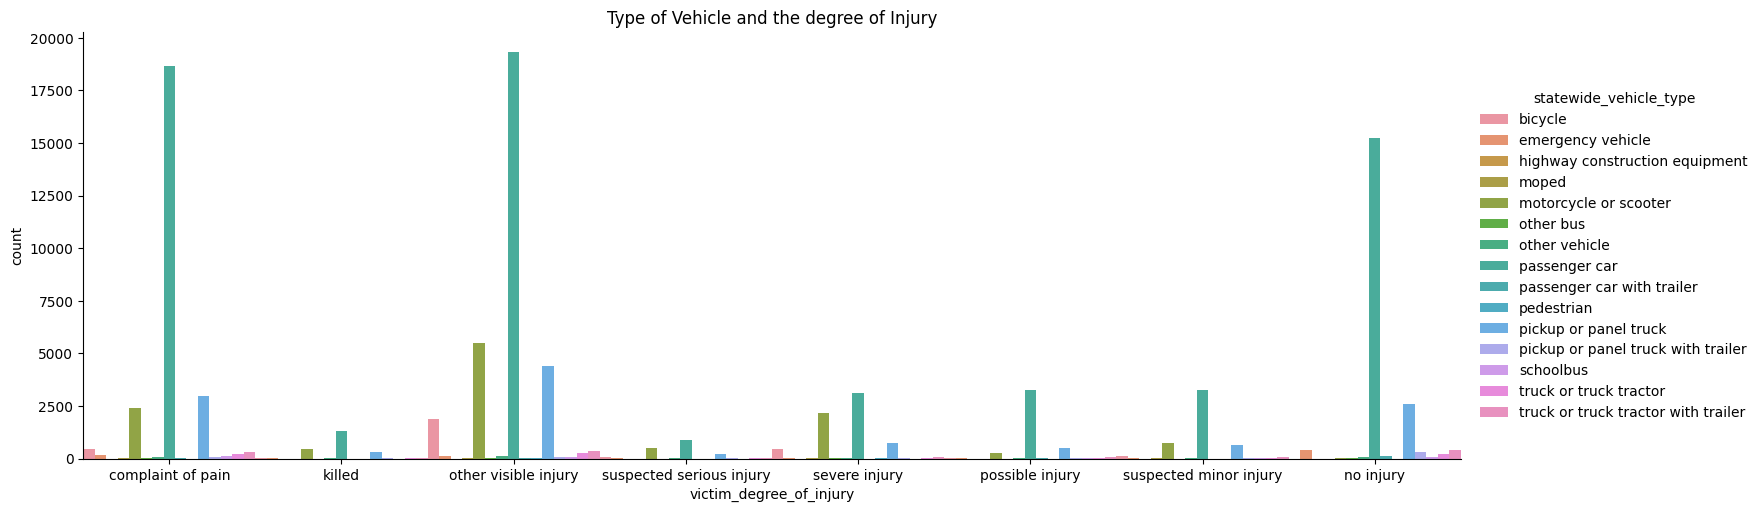

In [10]:
vehicle_type_count = df.groupby(['victim_degree_of_injury', 'statewide_vehicle_type']).size().reset_index(name='count')
vehicle_type_sorted = vehicle_type_count.sort_values(by='statewide_vehicle_type')

sns.catplot(data=vehicle_type_sorted, x='victim_degree_of_injury',y='count', hue='statewide_vehicle_type', kind='bar', width=1, aspect=3)

plt.title('Type of Vehicle and the degree of Injury')
plt.show()

Text(0.5, 1.0, 'Collision Count by Victim Age')

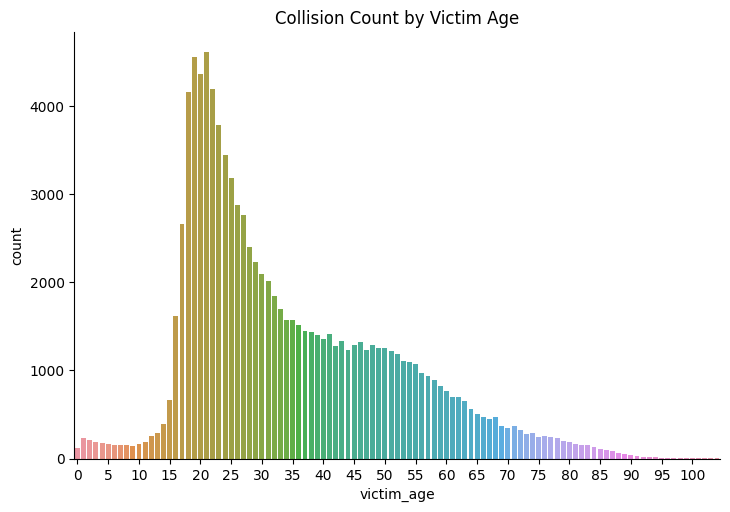

In [11]:
from matplotlib.ticker import MultipleLocator
victim_age_count = df.groupby(['victim_age']).size().reset_index(name='count')
victim_age_count['victim_age'] = victim_age_count['victim_age'].astype(int)
victim_age_count.columns = ['victim_age', 'count']

sns.catplot(data=victim_age_count, x='victim_age', y='count', kind='bar', aspect=1.5)
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.title('Collision Count by Victim Age')

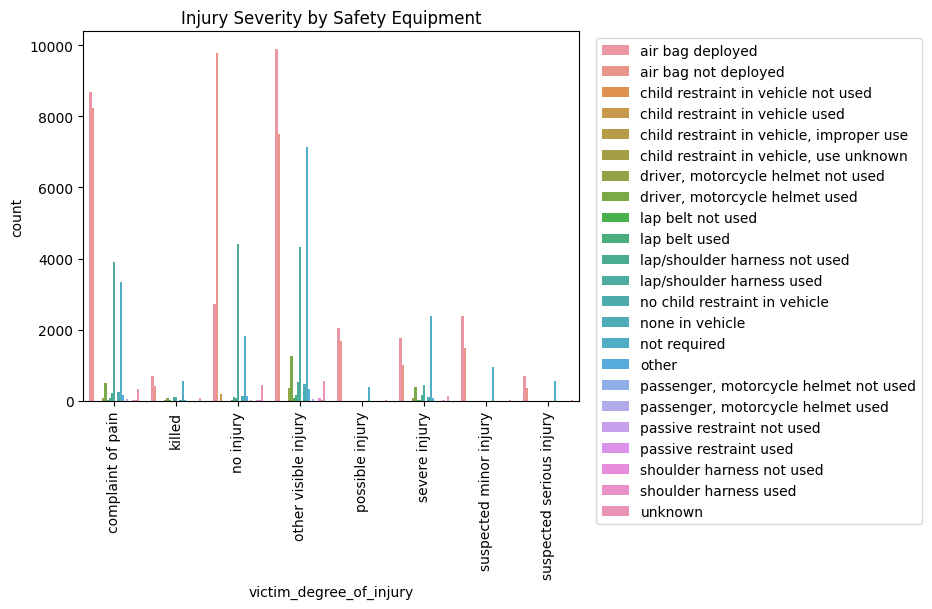

In [12]:
vehicle_type_count = df.groupby(['victim_degree_of_injury', 'victim_safety_equipment_1']).size().reset_index(name='count')

a = sns.barplot(data=vehicle_type_count, x='victim_degree_of_injury', y='count', hue='victim_safety_equipment_1')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
a.set_xticklabels(a.get_xticklabels(), rotation=90)

plt.title('Injury Severity by Safety Equipment')
plt.show()

1. **Injury Types Sorted by County Location:**
This chart depicts the distribution of collision locations and the corresponding degree of injury inflicted on the victims. It provides an overview of where most collisions occurred. Notably, there are several outlier counties in the dataset. The highest number of collisions took place in Los Angeles, which aligns with its status as the most populous county in California. The graph reveals that the majority of injuries fall into three categories: complaint of pain, no injury, and other visible injury.

2. **Number of Victims and the Degree of Injury:**
This bar chart examines the frequency of different degrees of injury experienced by victims. It indicates that "Other visible Injury" and "Complaint of pain" are the most commonly reported types of injuries among victims.

3. **Type of Collisions and the Degree of Injury:**
This chart provides insights into the relationship between the type of collisions and the resulting degree of injury. The dataset encompasses various collision types involving diverse vehicles, equipment, and pedestrians. The graph highlights that most collisions involved passenger cars, where victims reported a range of injuries, including other visible injuries, complaint of pain, or no injury at all. The second most prevalent collision type was motorcycles or scooters, where victims consistently suffered injuries, primarily falling into the categories of other visible injuries, complaint of pain, or severe injuries. The minimal difference between the number of severe injuries in motorcycle collisions and passenger car collisions indicates that the road poses a significant danger to motorcyclists. The close proximity of the injury counts for passenger cars and motorcycles in the severe injury category strongly suggests the high level of risk faced by motorcyclists on the road. In fact, the data shows there is a larger count of pedestrians walking out with no injury than motorcyclists in collisions.

4. **Collison Count by Victim Age:**
This chart provides a detailed examination of the age distribution of victims across all collisions. The data reveals that a significant proportion of collisions involve drivers aged 18-23, indicating that newer and potentially less experienced drivers are more frequently involved in these incidents. This observation suggests a potential correlation between younger drivers and a higher propensity for reckless behavior or a lack of experience, leading to their increased involvement in collisions.


5. **Injury Severity by Safety Equipment:**
Most vehicle safety equipment is intended to keep passengers safe within the vehicle while driving. However, The data represented in this bar chart strongly provides evidence that deployed airbags play a role on the degree of victim injuries. Most collisions that involve a deployed airbag result in either a complaint of pain by the victim or other visible injuries. Additionally, when comparing the presence or absence of airbag deployment, a larger number of victims experience complaints of pain or other visible injuries when the airbag is deployed. This finding underscores the significant role played by deployed airbags in influencing the severity of injuries sustained by victims in collisions.  

## Data Transformation

Once the required sample size for this study was extracted, the dataset underwent manipulation to ensure its suitability for training and testing (step 4). Initially, a careful examination of the dataset was conducted to identify the relevant features for the study. As part of the analysis process, a group discussion was conducted, incorporating domain knowledge and correlation analysis. To ensure a comprehensive understanding of the dataset, the group referred to the data dictionary provided by UC Berkeley [2], which offered detailed information about the dataset's variables and their respective meanings. This collaborative effort allowed for a more informed exploration and interpretation of the data, leveraging both domain expertise and analytical techniques. The original dataset consisted of 116 features, which were subsequently reduced to 43 after thorough examination process. 

In [13]:
columns_to_drop = ["number_of_collisions","jurisdiction",
                    "officer_id","reporting_district",
                    "chp_shift","county_city_location",
                    "special_condition","beat_type",
                    "chp_beat_type","city_division_lapd",
                    "chp_beat_class","beat_number",
                    "primary_road","secondary_road",
                    "distance","direction",
                    "weather_2","caltrans_county",
                    "caltrans_district","state_route",
                    "route_suffix","postmile_prefix",
                    "postmile","location_type",
                    "ramp_intersection","side_of_highway",
                    "tow_away","party_count",
                    "primary_collision_factor","pcf_violation_code",
                    "pcf_violation_category","pcf_violation",
                    "pcf_violation_subsection","hit_and_run",
                    "motor_vehicle_involved_with","pedestrian_action",
                    "road_condition_2","control_device",
                    "chp_road_type","pedestrian_collision",
                    "bicycle_collision","motorcycle_collision",
                    "truck_collision","not_private_property",
                    "statewide_vehicle_type_at_fault","chp_vehicle_type_at_fault",
                    "primary_ramp","secondary_ramp",
                    "latitude","longitude",
                    "process_date","id_x",
                    "party_number_x","party_type",
                    "at_fault","party_drug_physical",
                    "direction_of_travel","party_safety_equipment_1",
                    "party_safety_equipment_2","financial_responsibility",
                    "school_bus_related","oaf_violation_code",
                    "oaf_violation_category","oaf_violation_section",
                    "oaf_violation_suffix","other_associate_factor_1",
                    "other_associate_factor_2","vehicle_make",
                    "chp_vehicle_type_towing","chp_vehicle_type_towed",
                    "id_y","party_number_y",
                    "victim_seating_position"]

df = df.drop(columns_to_drop, axis=1)

## Data Preparation


Once the data was prepared for insertion into a classifier, our next step involved completing the cleanup process to address any erroneous data. This involves columns such as 'hazardous_materials,' where the data was only filled for positive scenarios and left blank otherwise. Following this, we had to encode our label and convert them into numerical representations that can be processed by the classifiers. As many of the features are nominal categorical data, we specifically chose to use the OneHotEncoder to avoid introducing ordinality or bias. Subsequently, we split the data frame into separate training and test sets.


Finally, we constructed a pipeline to preprocess our data, incorporating the necessary steps for imputing any missing data for the remaining columns. This pipeline ensured that our data was properly prepared and ready for further analysis or modeling.

In [14]:
df['hazardous_materials'] = df['hazardous_materials'].fillna(0)
df['alcohol_involved'] = df['alcohol_involved'].fillna(0)

In [15]:
y = df["victim_degree_of_injury"].copy()

df = df.drop("victim_degree_of_injury", axis=1)

le = LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y, columns = ['victim_degree_of_injury'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)


In [16]:
num_attribs = ["case_id", "intersection", "state_highway_indicator", "killed_victims", "injured_victims", "alcohol_involved", "severe_injury_count", "other_visible_injury_count", "complaint_of_pain_injury_count", "pedestrian_killed_count", "pedestrian_injured_count", "bicyclist_killed_count", "bicyclist_injured_count", "motorcyclist_killed_count", "motorcyclist_injured_count", "party_age", "hazardous_materials", "cellphone_in_use", "party_number_killed", "party_number_injured", "vehicle_year", "victim_age"]
cat_attribs = ["population", "county_location", "weather_1", "collision_severity", "type_of_collision", "road_surface", "road_condition_1", "lighting", "collision_date", "collision_time", "party_sex", "party_sobriety", "cellphone_use_type", "movement_preceding_collision", "statewide_vehicle_type", "party_race", "victim_role", "victim_sex", "victim_safety_equipment_1", "victim_safety_equipment_2", "victim_ejected"]

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)], remainder="passthrough")


# Data Mining

Our data mining process was focused on discovering the optimal model with high accuracy and metrics. To achieve this goal, we employed a combination of various algorithms and techniques. We explored different machine learning algorithms, such as decision trees, random forests, support vector machines, logistic regression, and neural networks, among others. 
Afterwards, we proceeded to filter out specific algorithms that were not well-suited for the classification task or deemed overly complex. 

## Decision Tree Classifier

During this phase, we identified multiple machine learning algorithms that were deemed suitable for the dataset at hand. Among these algorithms, the first one we explored was the Decision Tree Classifier from the scikit-learn library. 
A preliminary analysis of the classifiers' accuracy illustrated that the model was highly suitable for the given task. Furthermore, among the three fully implemented models, this particular model demonstrated the fastest training time.

In [17]:
tree_clf = DecisionTreeClassifier(random_state=42)
pipeline = make_pipeline(preprocessing, tree_clf)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['case_id', 'intersection',
                                                   'state_highway_indicator',
                                                   'killed_victims',
                                                   'injured_victims',
                                                   'alcohol_involved',
                                                   'severe_injury_count',
                                                   'other_visible_in...
                                                   'road_condition_1',
                                                   'lighting', 'collision_date',
                                                   'collision_time',
                                                   'party_sex',
                                                   'party_sobriety',
                                                   'cellphone_use_type',
                                                   'movement_preceding_collision',
                                                   'statewide_vehicle_type',
                                                   'party_race', 'victim_role',
                                                   'victim_sex',
                                                   'victim_safety_equipment_1',
                                                   'victim_safety_equipment_2',
                                                   'victim_ejected'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

## Random Forest Classifier

Following the initial exploration with the Decision Tree Classifier, our next choice of machine learning algorithm was the Random Forest Classifier. Our objective was to compare the performance of a single decision tree against an ensemble of multiple decision trees. With this approach, we aimed to assess the impact of ensemble learning and evaluate whether the Random Forest Classifier could outperform the individual decision tree model. 

In [18]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline2 = make_pipeline(preprocessing, rf_classifier)
pipeline2.fit(X_train, y_train)

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['case_id', 'intersection',
                                                   'state_highway_indicator',
                                                   'killed_victims',
                                                   'injured_victims',
                                                   'alcohol_involved',
                                                   'severe_injury_count',
                                                   'other_visible_in...
                                                   'road_condition_1',
                                                   'lighting', 'collision_date',
                                                   'collision_time',
                                                   'party_sex',
                                                   'party_sobriety',
                                                   'cellphone_use_type',
                                                   'movement_preceding_collision',
                                                   'statewide_vehicle_type',
                                                   'party_race', 'victim_role',
                                                   'victim_sex',
                                                   'victim_safety_equipment_1',
                                                   'victim_safety_equipment_2',
                                                   'victim_ejected'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

## Gradient Boosting Classifier

After exploring the Decision Tree Classifier and Random Forest Classifier, we proceeded to test the third machine learning algorithm: Gradient Boosting Classifier. By incorporating the Gradient Boosting Classifier into our analysis, we aimed to leverage its ability to capture intricate patterns and produce highly accurate predictions. In order to achieve a model with high accuracy, we conducted experiments by adjusting the learning rate and the number of estimators for the Gradient Boosting Classifier. By tinkering with these parameters, we aimed to find the optimal combination that would maximize the accuracy of the Gradient Boosting Classifier. Due to the time constraints associated with training the model, we were compelled to reduce the number of estimators employed in the model. By scaling down the number of estimators, we aimed to decrease the overall training time while still achieving reasonable performance.

In [19]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, random_state=42)
pipeline3 = make_pipeline(preprocessing, gb_classifier)
pipeline3.fit(X_train, y_train)

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['case_id', 'intersection',
                                                   'state_highway_indicator',
                                                   'killed_victims',
                                                   'injured_victims',
                                                   'alcohol_involved',
                                                   'severe_injury_count',
                                                   'other_visible_in...
                                                   'lighting', 'collision_date',
                                                   'collision_time',
                                                   'party_sex',
                                                   'party_sobriety',
                                                   'cellphone_use_type',
                                                   'movement_preceding_collision',
                                                   'statewide_vehicle_type',
                                                   'party_race', 'victim_role',
                                                   'victim_sex',
                                                   'victim_safety_equipment_1',
                                                   'victim_safety_equipment_2',
                                                   'victim_ejected'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5,
                                            random_state=42))])

# Evaluation

### DTC Evaluation

In sections 3.1 to 3.3, we introduced three machine learning classifiers that were deemed suitable for our dataset. To assess the strengths and weaknesses of our models, we partitioned our dataset into separate training and test sets, as described in section 2.3. Next, we will evaluate the performance of our models by predicting the outcomes on the test set and generate comprehensive evaluation metrics such as classification reports and confusion matrices. These analysis tools will provide valuable insights into the accuracy and effectiveness of our models in classifying the test data.

In [20]:
predictions = pipeline.predict(X_test)
predictions

array([2, 0, 5, ..., 5, 0, 0])

In [21]:
print(classification_report(y_test, predictions, 
    target_names=['complaint of pain', 'killed', 'no injury', 'other visible injury',
    'possible injury', 'severe injury', 'suspected minor injury', 'suspected serious injury']))

                          precision    recall  f1-score   support

       complaint of pain       0.91      0.96      0.93      5348
                  killed       1.00      1.00      1.00       438
               no injury       1.00      1.00      1.00      4106
    other visible injury       0.90      0.96      0.93      6870
         possible injury       0.55      0.35      0.43       821
           severe injury       0.85      0.91      0.88      1410
  suspected minor injury       0.51      0.31      0.39      1017
suspected serious injury       0.49      0.35      0.41       347

                accuracy                           0.90     20357
               macro avg       0.78      0.73      0.74     20357
            weighted avg       0.88      0.90      0.89     20357



Looking at the above classification report for our Decision Tree Classifier, we can see that some classes of our "victim_degree_of_injury" target variable perform substantially better than others. We know that precision represents the ratio between true positives and all positives - the degree to which DTC is able to identify only correct instances of each class. In the context of our study, it is the measure of instances that we correctly identify as being members of a given class, out of all the instances that are actually members. For complaint_of_pain, killed, no injury, other visible injury, and severe injury, we can see that our DTC performs quite well in terms of precision with all being >= 0.85. For possible injury, suspected minor injury, and suspected serious injury, the precision score drops significantly.

Recall, on the other hand, is a measure of how well DTC correctly identifies true positives. That is, for all the actual members of each class, how many did DTC correctly identify as being members of that class? Again, we can see that the same previously mentioned classes that performed well in terms of precision, also yielded a promising recall score. In fact, for each of these classes, recall was slightly higher than precision. However, for the classes that struggled with precision (i.e. possible injury, suspected minor injury, suspected serious injury), their recall score dropped even lower.

In further considering the effectiveness of this model, it is important to note that sometimes precision and recall alone are not sufficient. Especially in the case where injury severity predictions may be used to allocate first responder resources, a model with high precision for each class is great (i.e. if it claims the injury severity will be severe injury and is correct 85% of the time), however if it has low recall (i.e. it only detects a fraction of the actual severe injuries) this seriously undermines the perceived effectiveness of our model. To this end, it is important to also consider the F1 score.

The F1 score is a harmonic mean of the precision and recall values and is oftentimes easier to work with than trying to individually tailor precision and recall independently. Instead of trying to balance the two metrics, we can simply aim for a good F1 score and thus guarantee an optimal precision and recall value. In our example, we did not have a major imbalance between precision and recall for any scores, so the F1 scores are relatively high. The only classes that experience a low F1 score are the same possible injury, suspected minor injury, and suspected serious injury classes that we have already mentioned - all of which also have low precision and recall scores.

In terms of overall accuracy, DTC seems to perform fairly well at 90%. In spite of 3 of the 7 target classes performing quite poorly, these classes are rather small in size compared to the dataset and this is reflected in the weighted average results instead of the macro average.

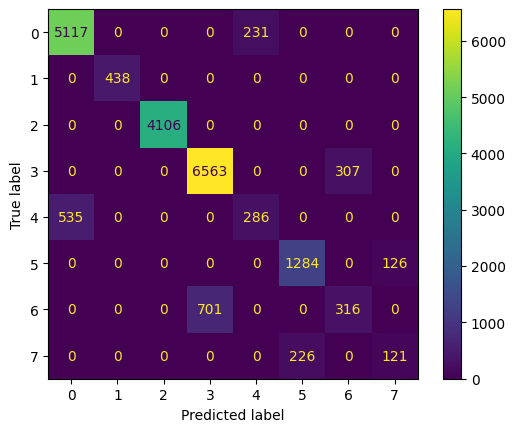

In [22]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

We can see from the DTC confusion matrix that the majority of instances are correctly classified, however as the classification report already indicated, there are some obvious errors as well. There appear to be several pairs of classes that are especially prone to misclassification in both directions. Well over half of the 'possible injury' instances are misclassified as 'complaint_of_pain', and the same mistake occurs in the opposing direction although to a lesser degree (535 / 231). Similarly, 'suspected minor injury' is frequently misclassified as 'other visible injury' and vice versa (701 / 307), and there are further inaccuracies in assigning classifications between 'suspected serious injury and 'severe injury' (226 / 126). It would seem that DTC generally performs well, but struggles to differentiate between classes that are similar in severity / are somewhat ambiguous in their scope. One possible explanation for this could be that the feature variables values for instances of 'complaint_of_pain' are very similar to those of 'possible injury' in the training set, leading the model to perform poorly in accurately building these classes for the testing set.

## RFC Evaluation

In [23]:
predictions2 = pipeline2.predict(X_test)
predictions2

array([2, 0, 5, ..., 5, 0, 0])

In [24]:
print(classification_report(y_test, predictions2, 
    target_names=['complaint of pain', 'killed', 'no injury', 'other visible injury',
    'possible injury', 'severe injury', 'suspected minor injury', 'suspected serious injury']))

                          precision    recall  f1-score   support

       complaint of pain       0.87      1.00      0.93      5348
                  killed       1.00      1.00      1.00       438
               no injury       1.00      1.00      1.00      4106
    other visible injury       0.88      1.00      0.93      6870
         possible injury       0.90      0.06      0.12       821
           severe injury       0.81      1.00      0.89      1410
  suspected minor injury       0.88      0.05      0.09      1017
suspected serious injury       0.78      0.06      0.11       347

                accuracy                           0.90     20357
               macro avg       0.89      0.65      0.64     20357
            weighted avg       0.90      0.90      0.86     20357



Unlike the DTC, the RFC classification report shows much better performance over all 8 injury severity classes in terms of precision, however the recall values have changed significantly. For complaint_of_pain, killed, no injury, other visible injury, and sever injury, recall has improved to 100%, but for possible injury, suspected minor injury, and suspected serious injury, recall has dropped to <= 6%. Of the positives the latter 3 classes are predicting, they are often right, however they are misclassifying 90+% of the instances in these classes so their recall is horrible. We can see these glaring classification deficiencies in the F1 scores for these 3 classes which are all below 0.12. The low F1 scores for these classes indicate a lack of balance between precision and recall, reflecting the difficulty of accurately predicting instances in these specific severity classes.

We can see the accuracy of this model is 90% (or 86% if using a weighted average), which suggests that RFC is actually doing okay. However, this metric doesn't really capture the fact that RFC does well for some classes and absolutely horribly for others.

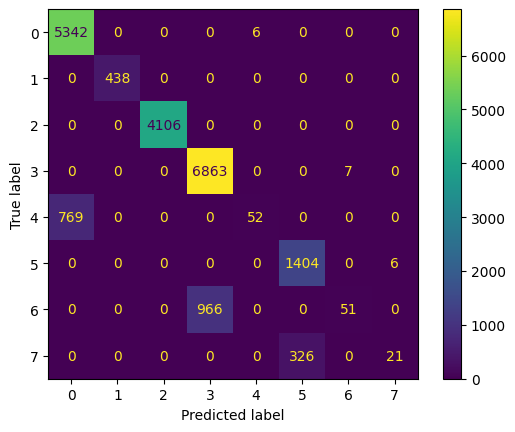

In [25]:
cm2 = confusion_matrix(y_test, predictions2)
cm_display = ConfusionMatrixDisplay(cm2).plot()

The confusion matrix for the RCF clearly shows the same improvements in classification for complaint_of_pain, killed, no, injury, other visible injury, and severe injury, but deterioration for possible injury, suspected minor injury, and suspected serious injury. Nearly all of the 'possible injury' instances are classified as 'complaint of pain', however this error is largely one-directional with very few 'complaint of pain' instances being classified as 'possible injury' (769, 6). Similarly, nearly all of 'suspected minor injury' are misclassified as 'other visible injury' (966, 7), and the same for 'suspected serious injury' being incorrectly classified as 'severe injury' (326, 6).

Since RCF employs many decision trees that are then combined, as opposed to a single decision tree for DTC, it is able to minimize overfitting and produce more accurate and precise results, which we can see. However, it is still struggling with differentiating between the same class pairs as DTC. Again, we believe that this is because of class imbalance and poor class separability in the data set. Some possible solutions to fix this could be to use stratified sampling to try and correct the class imbalance, or to collect more complete data for the problematic class pairs to improve the separability between them.

## GBC Evaluation

In [26]:
predictions3 = pipeline3.predict(X_test)
predictions3

array([2, 0, 5, ..., 5, 0, 0])

In [27]:
print(classification_report(y_test, predictions3, 
    target_names=['complaint of pain', 'killed', 'no injury', 'other visible injury',
    'possible injury', 'severe injury', 'suspected minor injury', 'suspected serious injury']))

                          precision    recall  f1-score   support

       complaint of pain       0.89      0.99      0.94      5348
                  killed       1.00      1.00      1.00       438
               no injury       1.00      1.00      1.00      4106
    other visible injury       0.91      0.98      0.94      6870
         possible injury       0.75      0.19      0.30       821
           severe injury       0.83      0.96      0.89      1410
  suspected minor injury       0.73      0.34      0.47      1017
suspected serious injury       0.54      0.20      0.30       347

                accuracy                           0.91     20357
               macro avg       0.83      0.71      0.73     20357
            weighted avg       0.90      0.91      0.89     20357



The GBC classification report shows a more similar performance with respect to precision and recall to that of DTC. While precision dropped slightly for some of the 5 separable classes (i.e. complaint_of_pain, killed, no injury, other visible injury, severe injury), it improved for the 3 remaining classes that have been difficult to separate. Recall was fairly similar for the 5 classes and slightly improved (on average) for the 3 remaining classes. If we compare the F1 scores of the 8 classes with that of DTC, we can see that GBC scores much higher overall than RFC and slightly higher than DTC in all classes except 'possible injury' and 'suspected serious injury'.

Like RFC, GBC typically achieves better accuracy than DTC by making use of many decision trees as opposed to just one. However, unlike RFC, GBC aggregates the results of each decision tree throughout the classification process whereas RFC performs this task at the very end. Typically, this results in better accuracy than RFC however in terms of this single metric, we can see GBC performance dropped slightly. One possible explanation for this is that GBC is overfitting slightly more than RFC and could benefit from hyperparameter tuning.

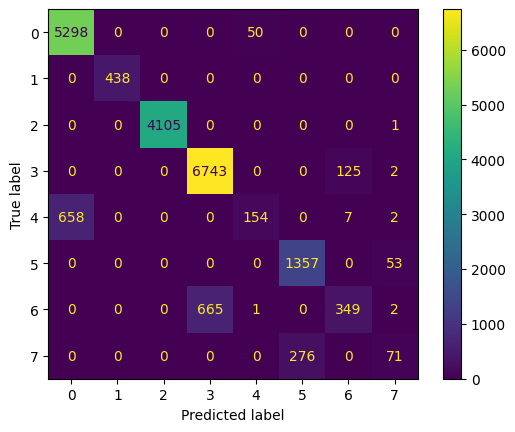

In [28]:
cm3 = confusion_matrix(y_test, predictions3)
cm_display = ConfusionMatrixDisplay(cm3).plot()

Again, we can see the results of GBC in the confusion matrix above. Similar to DTC and RFC, GBC struggles with classifying the previously mentioned class pairs - ('complaint of pain' / 'possible injury', 'suspected minor injury' / 'other visible injury', 'suspected serious injury' / 'severe injury'), however performs reasonably well at classifying the others. Even though the confusion matrix is not as clean as that for RFC, the recall across all classes is slightly better. For the purpose of this study, where we ideally want to be accurate in the positive predictions we make and also want to correctly classify as many actual members of each class as possible, we are trying to seek the optimal balance between precision and recall. Even though RFC offers better precision, the recall is troubling low. Yes, with RFC we are accurate in the predictions we are making, but the quantity of correctly classified class members is much too low. To that end, we collectively agree that GBC offers the best balanced performance of the three classifiers we have considered.

## Observations

In section 4.1, we presented an overview of the machine learning models employed in this project, along with their corresponding classification reports. During our analysis of the classifiers, we observed a consistent trend among certain target names, namely 'possible injury', 'suspected minor injury', and 'suspected serious injury'. These specific categories exhibited relatively low scores in terms of precision, recall, and f1-score, indicating potential challenges in accurately predicting and classifying instances belonging to these categories. 

(0.7, 1.0)

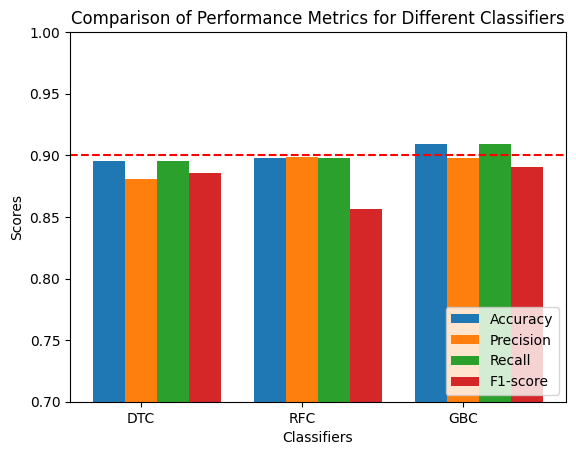

In [29]:
acc1, acc2, acc3 = accuracy_score(y_test, predictions), accuracy_score(y_test, predictions2), accuracy_score(y_test, predictions3)
prec1, prec2, prec3 = precision_score(y_test, predictions, average='weighted'), precision_score(y_test, predictions2, average='weighted'), precision_score(y_test, predictions3, average='weighted')
rc1, rc2, rc3 = recall_score(y_test, predictions, average='weighted'), recall_score(y_test, predictions2, average='weighted'), recall_score(y_test, predictions3, average='weighted')
f11, f12, f13 = f1_score(y_test, predictions, average='weighted'), f1_score(y_test, predictions2, average='weighted'), f1_score(y_test, predictions3, average='weighted')

classifiers = ['DTC','RFC','GBC']

bar_width = 0.2

# Assigning them side by side
r1 = np.arange(len(classifiers))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting the bar plot
plt.bar(r1, [acc1, acc2, acc3], width=bar_width, label='Accuracy')
plt.bar(r2, [prec1, prec2, prec3], width=bar_width, label='Precision')
plt.bar(r3, [rc1, rc2, rc3], width=bar_width, label='Recall')
plt.bar(r4, [f11, f12, f13], width=bar_width, label='F1-score')

plt.axhline(y=0.9, color='r', linestyle='--')

plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.title('Comparison of Performance Metrics for Different Classifiers')
plt.xticks([r + bar_width for r in range(len(classifiers))], classifiers)
plt.legend(loc='lower right')
plt.ylim(0.7, 1.0)

In the depicted graph above, we can observe the performance metrics of each classifier, namely accuracy, precision, recall, and F1-score, in relation to one another. The graph presented offers a comprehensive overview of the performance of each classifier across multiple evaluation metrics, providing valuable insights that enable us to compare and assess the strengths and weaknesses of each classifier. The graph highlights the notable performance of the Decision Tree Classifier (DTC) across all evaluated metrics. It is evident that the DTC exhibited commendable results, displaying a balanced performance across various aspects. The consistent performance of the DTC across multiple metrics reinforces its reliability and suggests its potential as a reliable choice for the given dataset and analysis objectives.

Upon examining the graph for the Random Forest Classifier (RFC), we can discern that the RFC achieved higher scores than other classifiers in the majority of performance metrics, with the exception of the F1 score. While the RFC's exhibited higher accuracy, precision, and recall compared to its counterparts, indicating its effectiveness in correctly classifying instances and minimizing both false positives and false negatives, it is important to note that the F1 score was lower. This suggests a potential trade-off between precision and recall in the classifier's predictions. Although the RFC obtained a lower F1 score, the RFC is a promising choice for the given dataset, particularly when the focus is placed on achieving higher levels of accuracy, precision, and recall, rather than solely optimizing the F1 score.

If we analyze the graph for the Gradient Boosting Classifier (GBC), it becomes evident that it outperforms other classifiers across all performance metrics. The classifier consistently achieves higher scores in terms of accuracy, precision, recall, and F1-score. The exception to this trend is the precision metric exhibited by the RFC. Nevertheless, the Gradient Boosting Classifier outperforms the other models across various metrics and making it the superior choice for this particular dataset.

Another crucial aspect to consider is the training speed of the models. It is worth mentioning that selecting an appropriate collaborative platform was essential to ensure efficient collaboration and productivity throughout the project. After careful consideration and extensive research, we made the decision to utilize Deepnote as our collaborative platform of choice. Deepnote provided us with a real-time collaboration environment that greatly enhanced our team's productivity and efficiency.

However, the computational resources and infrastructure provided by Deepnote were not as robust as we had anticipated. As a result, we encountered slower training times for our models, which unfortunately created bottlenecks in the development process of this project. To compensate, we lowered the sample size to 100,000 (originally 300,000) and tinkered with optimal training settings.


With our sample size and extensive feature list, we encountered varying training speeds across the different models. Among the models we experimented with, the DTC exhibited the highest training speed, completing the training process in less than 30 seconds. The RFC came in second, taking an average of approximately 3 minutes for training. The GBC followed closely behind, averaging around 3 minutes and 30 seconds or more.

# Conclusion

In section 1 of our project, we extensively examined the issue of traffic collisions and their inherent risks to public safety. By exploring the vast dataset related to these incidents, we aimed to uncover valuable insights that could contribute to enhancing road safety measures, prioritizing injuries based on severity, and reducing the severity of injuries.

During the data analysis, several insightful graphs were generated, providing answers to the questions posed in the introduction. The findings can be summarized as follows:

&emsp; 1. Motorcyclist Injuries: The data strongly suggests that motorcyclists sustain more severe injuries compared to occupants of other vehicles, including pedestrians, involved in collisions. This finding highlights the vulnerability of motorcyclists on the road.

&emsp; 2. Collisions: Los Angeles County exhibits the highest number of collisions compared to all other counties in California. This data strongly indicates a higher frequency of accidents occurring in Los Angeles.

&emsp; 3. Driver Age and Collisions: A notable trend emerges, indicating that newer or less experienced drivers, particularly those in the age range of 18-23, are more likely to be involved in collisions. This observation suggests that the lack of experience among these drivers may contribute to their higher involvement in accidents.

&emsp; 4. Airbags and Victim Injuries: The data reveals a significant impact of airbag deployment on victim injuries during collisions. Specifically, victims tend to report complaints of pain or other visible injuries when airbags are deployed, in contrast to collisions where airbags are not deployed. This underscores the role of airbags in influencing the severity of injuries sustained by collision victims.

Overall, these findings shed light on various aspects related to collision patterns, motorcyclist injuries, driver age, and the influence of airbags on victim injuries. They provide valuable insights into the dynamics of collisions and highlight potential areas for further analysis and targeted safety measures.After completing the analysis stage, the next step involved processing the data. During this stage, various techniques and methods were employed to manipulate, clean, and transform the dataset to prepare it for further analysis or modeling.

We began by preprocessing the dataset, which involved data cleaning, encoding labels, and splitting the data into training and testing sets. Throughout the modeling phase, we explored various machine learning algorithms, including Decision Tree Classifier, Random Forest Classifier, and Gradient Boosting Classifier from scikit-learn. Each algorithm was evaluated based on performance metrics such as accuracy, precision, recall, and F1-score.

Furthermore, the comparison of the different classifiers highlighted distinct strengths and weaknesses. The Decision Tree Classifier demonstrated quick training time and decent performance, while the Random Forest Classifier offered higher accuracy and improved metrics at the expense of significantly longer training time. The Gradient Boosting Classifier showed promising results after tuning the learning rate and number of estimators, although it required more computational resources due to longer training times.


Lastly, we assessed the performance of these models by evaluating key metrics such as accuracy, precision, recall, and F1 score. Based on the classification reports, it was determined that the GBC exhibited the best performance for our dataset. However, it came at the cost of a longer training time compared to other models. 



# References 

[1] Gude, A. (2021) California traffic collision data from SWITRS, Kaggle. Available at: https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs (Accessed: 24 June 2023). 

[2] Transportation Injury Mapping System (no date) TIMS. Available at: https://tims.berkeley.edu/help/SWITRS.php (Accessed: 24 June 2023). 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=015741ff-b0ac-4ba7-a1bd-80b35f83a738' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>